# Data pre-processing to make it ready for the model to learn

1. Transform temporal features
2. Standardize continuous features
3. Transform continuous features to logarithmic scale
4. Remove outliers
5. Transform categorical features into boolean


In [88]:
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=Warning)
np.seterr(divide='ignore', invalid='ignore')


# Hide deprecated warnings
import warnings
warnings.filterwarnings('ignore')

## Load the clean dataset form previous notebook

In [89]:
# Load data from the folder where I uploaded the csv file
data = pd.read_csv("/Users/gjg/code/giovjg/datascience/house_price_project/datasets/data_cleanGiov.csv")

In [90]:
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,set,log_SalePrice
0,856,854,0,unknown,3,1Fam,TA,No,706.0,0.0,...,Pave,8,856.0,AllPub,0,2003,2003,2008,train,12.247694
1,1262,0,0,unknown,3,1Fam,TA,Gd,978.0,0.0,...,Pave,6,1262.0,AllPub,298,1976,1976,2007,train,12.109011
2,920,866,0,unknown,3,1Fam,TA,Mn,486.0,0.0,...,Pave,6,920.0,AllPub,0,2001,2002,2008,train,12.317167
3,961,756,0,unknown,3,1Fam,Gd,No,216.0,0.0,...,Pave,7,756.0,AllPub,0,1915,1970,2006,train,11.849398
4,1145,1053,0,unknown,4,1Fam,TA,Av,655.0,0.0,...,Pave,9,1145.0,AllPub,192,2000,2000,2008,train,12.429216


In [91]:
def transform_continuous_to_logarithmic_scale(series):
  # Transform to logarithmic scale
  return np.log(series)

def binarize_continuous_variable(series):
    return pd.cut(series, 2, labels=[0,1]).astype(int)

def one_hot_encode_categorical_variables(series, name):
    return pd.get_dummies(series, prefix=name)

def remove_outliers_by_IQR_criteria(data, feature_name, multiplier):
    data = data.copy()
  # Calculate IQR
    len(data[feature_name])
    quartiles, Qs = pd.qcut(data[feature_name].rank(method='first'), q=4, 
                        labels=['peak1','peak2','peak3','peak4'], retbins=True)

    IQR = Qs[3] - Qs[1]
    Q1 = Qs[1]
    Q3 = Qs[3]
    # Define the threshold in the distribution to consider outlier at the left and right side of the distribution
    min_value = Q1 - (multiplier*IQR)
    max_value = Q3 + (multiplier*IQR)
    condition_min = (data[feature_name] >= min_value)
    condition_max = (data[feature_name] <= max_value)
    # Remove outliers out of [Q1-multiplier*IQR, Q3+multiplier*IQR]
    print("Before removing outliers in {} you had {} records".format(feature_name, len(data)))
    data = data[condition_min & condition_max]
    print("After removing outliers in {} you have {} records".format(feature_name, len(data)))
    return data

def normalize(series):
    series_ = series.copy()
    max_value = series_.max()
    min_value = series_.min()
    result = (series_ - min_value) / (max_value - min_value)
    return result

def standardize_continuous_feature(series):
  # First, normalize your data to avoid large values when standardizing
    normalized_values = normalize(series)
  # Then standardize the data with the formula z = (x - u) / s
    mean_sample = np.mean(normalized_values)
    std_sample = np.std(normalized_values)
    scaled_data = (normalized_values - mean_sample) / std_sample
    return scaled_data

In [92]:
# Check the dimensions of the dataset
data.shape

(2919, 83)

In [93]:
data.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'Id', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'Po

In [94]:
# Check the data types and if there are missing values
# data.info()

## Transform temporal features

 

In [95]:
# Transform year features into continuous ones by calculating the delta in comparison with current year
year_features = ['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']
new_year_features = ['diff_YearBuilt','diff_YearRemodAdd','diff_GarageYrBlt','diff_YrSold']

In [96]:
# Calculate difference between the given year and the current year
data_clean1 = data.copy()
current_year = 2019

# run it without the for loop
# data_clean1[year_features].apply(lambda x: current_year - x)

for i, feature in enumerate(year_features):
  #calculate diff in years and store it as the values in a new list
    dif = current_year - data_clean1[feature] #-> lambda
    new_column_name = new_year_features[i] # -> extract the element from new_year_features
    data_clean1[new_column_name] = dif # -> assign the new series to a new column
  
  #calculate the difference between the current year and the values of each column
    new_column_name = new_year_features[i]
    data_clean1[new_column_name] = data_clean1[feature].apply(lambda x: current_year - x)

In [97]:
# drop old columns year_features and leave the new ones
data_clean1 = data_clean1.drop(year_features, axis=1)

# Update the nominal and cardinal list of features after this change
cardinal = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
             'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
             'TotRmsAbvGrd','KitchenAbvGr',
             'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
             'ScreenPorch','PoolArea','MiscVal']

total_cardinal = cardinal + new_year_features

final_nominal = ['HouseStyle', 'PoolQC', 'GarageQual', 'OverallQual', 'SaleCondition', 'BldgType', 'KitchenQual', 
                 'Street', 'MSZoning', 'BedroomAbvGr', 'GarageCond', 'Foundation', 'Functional', 'Heating', 
                 'Utilities', 'BsmtQual', 'OverallCond', 'MasVnrType', 'MoSold', 'LandSlope', 'Electrical', 
                 'RoofMatl', 'CentralAir', 'HalfBath', 'LandContour', 'SaleType', 'GarageCars', 'MSSubClass', 
                 'Exterior2nd', 'BsmtFinType1', 'GarageFinish', 'Fireplaces', 'HeatingQC', 
                 'ExterQual', 'LotShape', 'BsmtFullBath', 'BsmtFinType2', 'ExterCond', 'Neighborhood', 
                 'BsmtHalfBath', 'RoofStyle', 'Exterior1st', 'Condition1', 'PavedDrive', 'Fence', 'BsmtCond', 
                 'FullBath', 'BsmtExposure', 'Alley', 'FireplaceQu', 'Condition2', 
                 'GarageType', 'MiscFeature', 'LotConfig']

In [98]:
data_clean1[new_year_features].head(2)

,diff_YearBuilt,diff_YearRemodAdd,diff_GarageYrBlt,diff_YrSold
0,16,16,16.0,11
1,43,43,43.0,12


## Standardize continuous variables

* Why do we need to do this?


In [99]:
total_cardinal

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'TotRmsAbvGrd',
 'KitchenAbvGr',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'diff_YearBuilt',
 'diff_YearRemodAdd',
 'diff_GarageYrBlt',
 'diff_YrSold']

In [100]:
new_cardinal_features = ['st_LotFrontage','st_LotArea','st_MasVnrArea','st_BsmtFinSF1','st_BsmtFinSF2',
             'st_BsmtUnfSF','st_TotalBsmtSF','st_1stFlrSF','st_2ndFlrSF','st_LowQualFinSF','st_GrLivArea',
             'st_TotRmsAbvGrd','st_KitchenAbvGr',
             'st_GarageArea','st_WoodDeckSF','st_OpenPorchSF','st_EnclosedPorch','st_3SsnPorch',
             'st_ScreenPorch','st_PoolArea','st_MiscVal','st_diff_YearBuilt','st_diff_YearRemodAdd',
             'st_diff_GarageYrBlt','st_diff_YrSold']

# Transform the continuous variables with standardscaler of sklearn
data_clean2 = data_clean1.copy()
# apply the standarize function to each of the cardinal columns
data_clean2[new_cardinal_features] = data_clean2[total_cardinal].apply(lambda x: standardize_continuous_feature(x))

In [101]:
data_clean2.head(2)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,st_OpenPorchSF,st_EnclosedPorch,st_3SsnPorch,st_ScreenPorch,st_PoolArea,st_MiscVal,st_diff_YearBuilt,st_diff_YearRemodAdd,st_diff_GarageYrBlt,st_diff_YrSold
0,856,854,0,unknown,3,1Fam,TA,No,706.0,0.0,...,0.200006,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,-1.046258,-0.896833,-0.853833,-0.157646
1,1262,0,0,unknown,3,1Fam,TA,Gd,978.0,0.0,...,-0.702843,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,-0.154764,0.395604,0.163556,0.602962


In [102]:
# Remove old columns
data_clean2 = data_clean2.drop(total_cardinal, axis=1)

## See if there are any binarized feature in your continuous ones

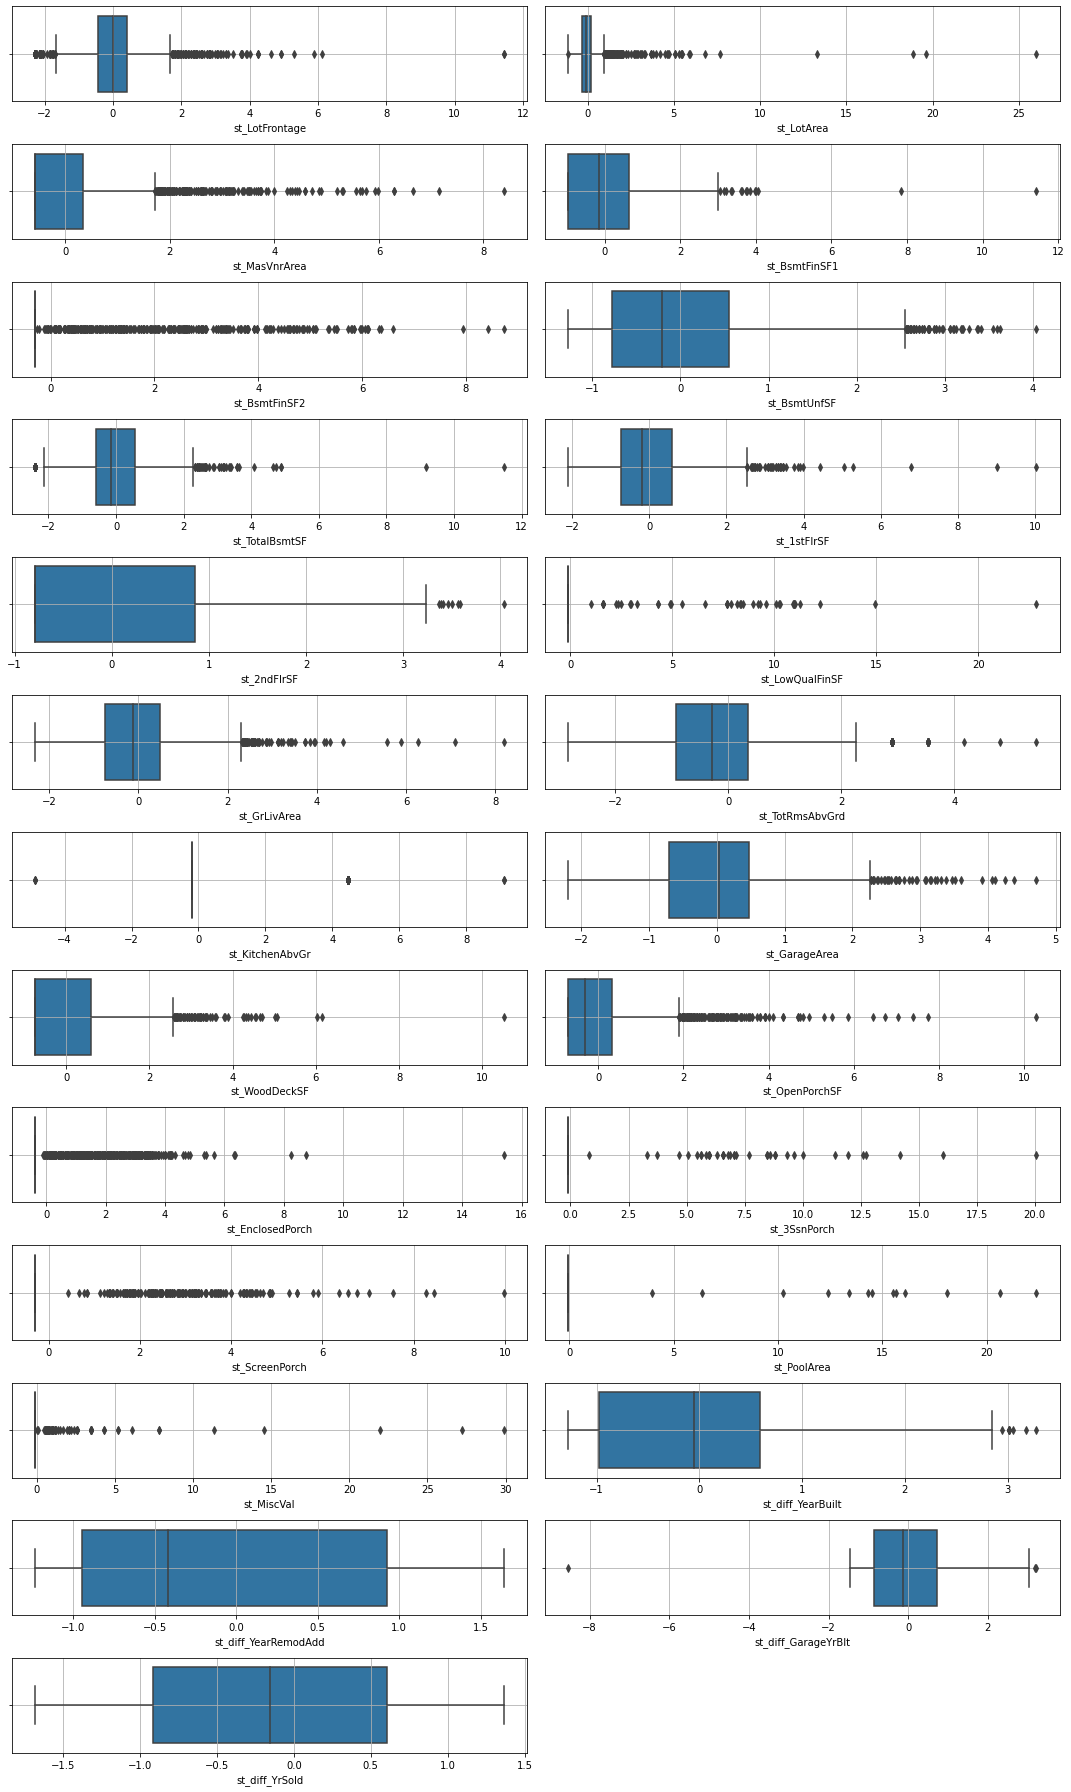

In [103]:
# Visualize the boxplots after normalization and standardization
plt.figure(figsize=(15,25))
for i, feature in enumerate(new_cardinal_features):
    plt.subplot(13,2, i+1)
    sns.boxplot(data_clean2[feature])
    plt.grid(True)
plt.tight_layout()

Write your conclusions. Is there any that should be transform into categories?

In [104]:
# Select those distributions that are mainly containing one unique value and outliers to binarize
cardinal_to_binarize = ['st_BsmtFinSF2','st_LowQualFinSF','st_KitchenAbvGr','st_EnclosedPorch','st_3SsnPorch',
                        'st_ScreenPorch','st_PoolArea','st_MiscVal']

# Binarize those variables with one unique value and many outliers
data_clean3 = data_clean2.copy()
data_clean3[cardinal_to_binarize] = data_clean3[cardinal_to_binarize].apply(lambda x: binarize_continuous_variable(x))

In [118]:
data_clean3[cardinal_to_binarize].head(5)

,st_BsmtFinSF2,st_LowQualFinSF,st_KitchenAbvGr,st_EnclosedPorch,st_3SsnPorch,st_ScreenPorch,st_PoolArea,st_MiscVal
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0


In [106]:
# Update the list of nominal and cardinal features
complete_nominal = final_nominal + cardinal_to_binarize
clean_cardinal = ['st_LotFrontage','st_LotArea','st_MasVnrArea','st_BsmtFinSF1',
             'st_BsmtUnfSF','st_TotalBsmtSF','st_1stFlrSF','st_2ndFlrSF','st_GrLivArea',
             'st_TotRmsAbvGrd','st_GarageArea','st_WoodDeckSF','st_OpenPorchSF',
             'st_diff_YearBuilt','st_diff_YearRemodAdd','st_diff_GarageYrBlt','st_diff_YrSold']

## Transform continuous variables to logarithmic scale to bulk the data

**See distribution plots of the rest of cardinal variables**

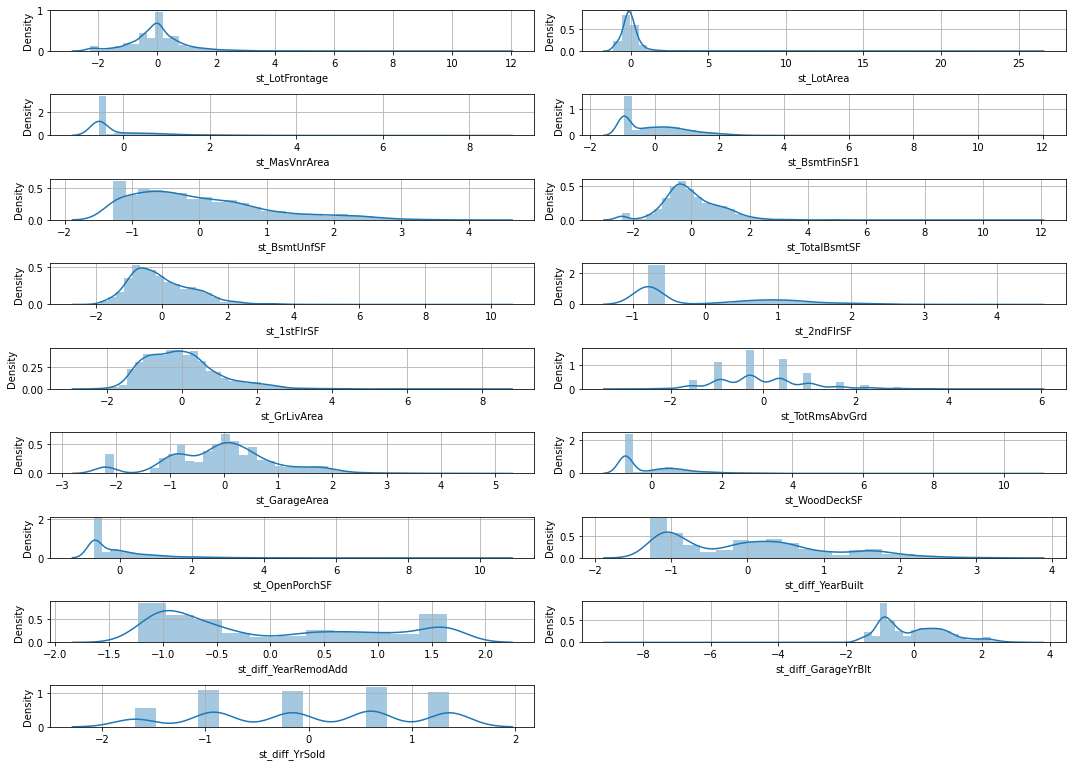

In [107]:
# Visualize the frequency distribution after normalization and standardization
plt.figure(figsize=(15,15))
for i, feature in enumerate(clean_cardinal):
    plt.subplot(13,2, i+1)
    sns.distplot(data_clean3[feature])
    plt.grid(True)
plt.tight_layout()

**Are there other features that you could binarize?**

Yes, we can see categories in 2ndFlorSF, WoodDeckSF, st_TotRmsAbvGrd, all the features related to Years.

## Transform the final cardinal features into logarithmic scale to bulk the distributions

In [108]:
# Take them from previous notebook
log_cardinal_features = ['log_LotFrontage','log_LotArea','log_MasVnrArea','log_BsmtFinSF1',
             'log_BsmtUnfSF','log_TotalBsmtSF','log_1stFlrSF','log_2ndFlrSF','log_GrLivArea',
             'log_TotRmsAbvGrd','log_GarageArea','log_WoodDeckSF','log_OpenPorchSF',
             'log_diff_YearBuilt','log_diff_YearRemodAdd','log_diff_GarageYrBlt','log_diff_YrSold']

# Apply the logarithmic transformation function defined above
data_clean4 = data_clean3.copy()
# for loop over the cardinal features to transfrom them:
#   apply the function transform to logarithm to each column
  
# Drop old cardinal features
data_clean4 = data_clean4.drop(new_cardinal_features, axis=1)

In [109]:
# Get the columns that have any missing value
s_missing_values = data_clean4.isnull().sum()
s_missing_values[s_missing_values > 0]

SalePrice        1459
log_SalePrice    1459
dtype: int64

## Remove outliers

In [133]:
# Remove outliers with the criteria of all elements out of the range [Q1 - IQR*1.5, Q3 + IQR*1.5]
data_clean5 = data_clean3.copy()

# Remove outliers multiplier criteria (default 1.5)
multiplier = 1.5
#for loop over the final cardinal features:
#apply the function to each column to remove outliers->aplying a function over the whole dataframe
#With the multiplier it calculates the whole data, to remove or not the outliers of the df.
#remove_outliers_by_IQR_criteria(df, feature_name, multiplier)

for feature in clean_cardinal:
    data_clean5 = remove_outliers_by_IQR_criteria(data_clean5, feature, multiplier)

Before removing outliers in st_LotFrontage you had 2919 records
After removing outliers in st_LotFrontage you have 2919 records
Before removing outliers in st_LotArea you had 2919 records
After removing outliers in st_LotArea you have 2919 records
Before removing outliers in st_MasVnrArea you had 2919 records
After removing outliers in st_MasVnrArea you have 2919 records
Before removing outliers in st_BsmtFinSF1 you had 2919 records
After removing outliers in st_BsmtFinSF1 you have 2919 records
Before removing outliers in st_BsmtUnfSF you had 2919 records
After removing outliers in st_BsmtUnfSF you have 2919 records
Before removing outliers in st_TotalBsmtSF you had 2919 records
After removing outliers in st_TotalBsmtSF you have 2919 records
Before removing outliers in st_1stFlrSF you had 2919 records
After removing outliers in st_1stFlrSF you have 2919 records
Before removing outliers in st_2ndFlrSF you had 2919 records
After removing outliers in st_2ndFlrSF you have 2919 records
Befo

In [132]:
# Get the columns that have any missing value
s_missing_values = data_clean5.isnull().sum()
s_missing_values[s_missing_values > 0]

SalePrice        1459
log_SalePrice    1459
dtype: int64

In [139]:
# Count the percentage of outliers discarded
percentage_outliers = (len(data_clean4)-len(data_clean5))/len(data_clean4) * 100
print("The percentage of outliers was {}%".format(percentage_outliers))

The percentage of outliers was 0.0%


In [140]:
#check of number of columns, to validate we did not lose any information.
len(data_clean5.columns)

83

## Dummify categorical variables



In [136]:
# Transform categorical variables into boolean new columns with pandas get_dummies function
data_clean6 = data_clean5.copy()

new_boolean_columns = []
for feature in complete_nominal:
    new_boolean_columns.append(one_hot_encode_categorical_variables(data_clean6[feature], feature))

In [141]:
df_new_boolean_columns = pd.concat(new_boolean_columns, axis=1)  
# Drop old categorical features
data_clean6 = data_clean6.drop(complete_nominal, axis=1)

# Append dummy categorical features (now boolean)
final_feature_vector = pd.concat([data_clean6, df_new_boolean_columns], axis=1)

In [142]:
# Get the columns that have any missing value
s_missing_values = final_feature_vector.isnull().sum()
s_missing_values[s_missing_values > 0]

SalePrice        1459
log_SalePrice    1459
dtype: int64

### Get the final shape of your feature vector dataframe

In [143]:
final_feature_vector.shape

(2919, 393)

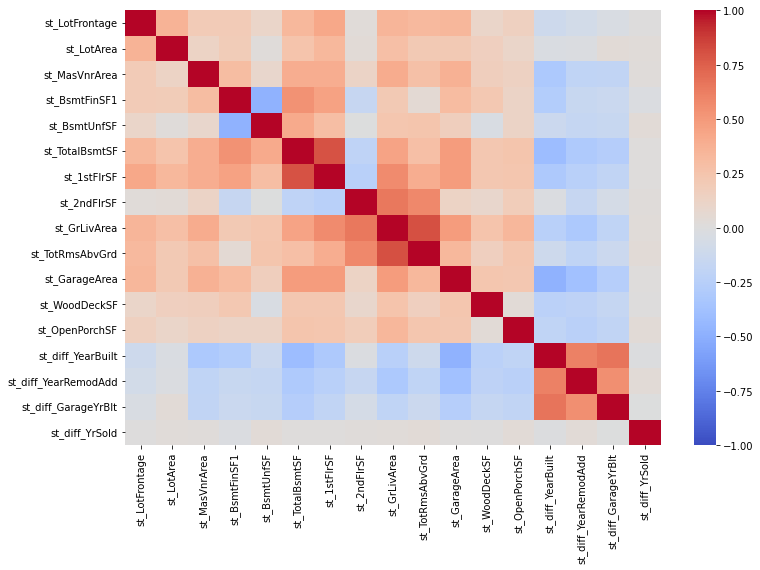

In [144]:
all_continous = ['log_SalePrice'] + clean_cardinal
_=plt.figure(figsize=(12,8))
_=sns.heatmap(final_feature_vector[clean_cardinal].corr(), vmin=-1, cmap="coolwarm")

**How do you think that the model will perform taking into account the dimensions of your data?**

Answer here

## Store the data into a new csv file

In [44]:
final_feature_vector.to_csv(" /Users/gjg/code/giovjg/datascience/house_price_project/datasets/final_feature_vector", index=False, encoding='utf-8')